![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Computing highly accurate mass transfer at rising bubbles

In this notebook, we cover the following topics:

1. The high Schmidt number problem
2. Decoupling two-phase flow and mass transfer
3. Two-phase flow simulation of a single rising bubble
4. Data processing and visualization
5. Creating models for deformation and velocity
6. Single-phase flow simulation with mass transfer
7. Analyzing the results

## The high Schmidt number problem

## Decoupling two-phase flow and mass transfer

## Data processing and visualization

In [1]:
from typing import List, Tuple
from glob import glob
from os.path import isdir
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
from pandas import DataFrame, read_csv, to_numeric

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# dataset directory
data = "../datasets/ellipsoidal_bubble/"

# set default dtype to double precision
pt.set_default_dtype(pt.float64)

# make results reproducible
pt.manual_seed(0)

# create output directory
output = "output"
!mkdir -p $output

In [2]:
def load_logfile(path: str) -> DataFrame:
    columns = ["t", "vol", "x", "y", "z", "ux", "uy", "uz"]
    log = read_csv(path, sep=" ", header=None, names=columns).dropna()
    log = log[to_numeric(log.t, errors="coerce").isnull() == False].reset_index(drop=True)
    return log.apply(to_numeric)

log = load_logfile(f"{data}log.solver")
log.head()
len(log)

8990

In [3]:
write_times = pt.arange(0.0, 15, 0.15)
xc = pt.zeros_like(write_times)
uxc = pt.zeros_like(write_times)
for i, t in enumerate(write_times):
    row = log.iloc[(log.t-t.item()).abs().argsort()[0]]
    xc[i] = row.x
    uxc[i] = row.ux

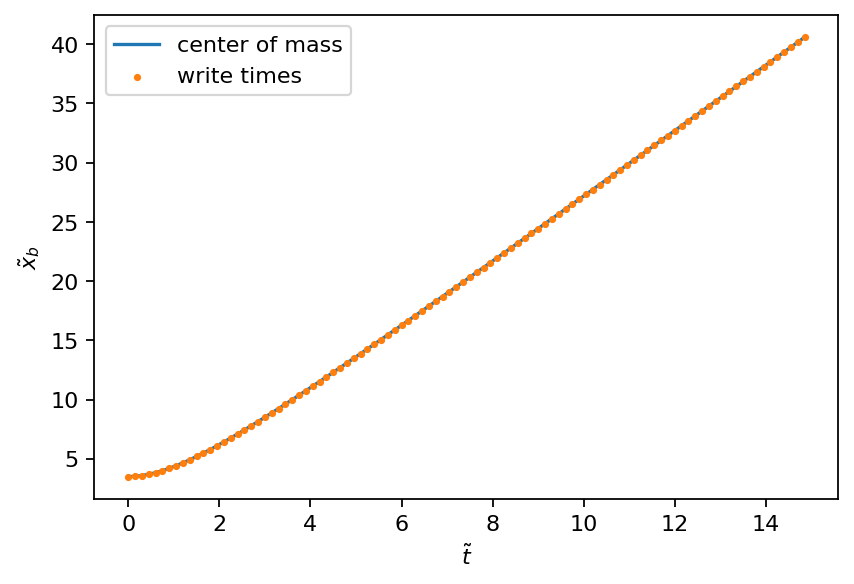

In [4]:
plt.plot(log.t, log.x, label="center of mass")
plt.scatter(write_times, xc, s=5, c="C1", label="write times", zorder=5)
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{x}_b$")
plt.savefig(f"{output}/bubble_position.svg", bbox_inches="tight")

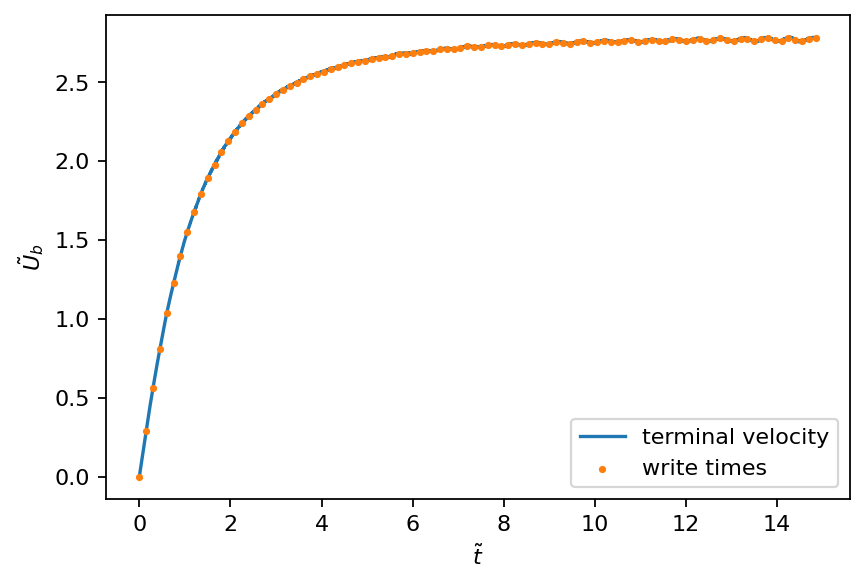

In [5]:
plt.plot(log.t, log.ux, label="terminal velocity")
plt.scatter(write_times, uxc, s=5, c="C1", label="write times", zorder=5)
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{U}_b$")
plt.savefig(f"{output}/bubble_speed.svg", bbox_inches="tight")

In [6]:
files = glob(f"{data}plic/*")
print(files[:2])
iterations = sorted(set([name.split("_")[-2] for name in files]), key=int)
assert len(iterations) == 100, "expected exactly 100 snapshots"

['../datasets/ellipsoidal_bubble/plic/points_000063_n003.txt', '../datasets/ellipsoidal_bubble/plic/points_000080_n003.txt']


In [7]:
def parse_processor_file(path: str) -> pt.Tensor:
    with open(path, "r") as f:
        lines = [list(map(float, line.strip().split(" "))) for line in f if line.strip()]
    return pt.tensor(lines)

parse_processor_file(files[0])[:2]

tensor([[25.4883,  0.5000,  0.5743, -0.4257,  1.7086, -1.4042],
        [25.4923,  0.5054,  0.5743, -0.4257,  1.6619, -1.4668]])

In [8]:
def load_interface_snapshot(path: str, iteration: int, np: int) -> pt.Tensor:
    p_data = []
    for p in range(np):
        p_data.append(
            parse_processor_file(f"{path}points_{iteration:06d}_n{p:03d}.txt")
        )
    p_data = pt.cat(p_data)
    return p_data[p_data[:, -1].abs() < 10]

load_interface_snapshot(f"{data}plic/", 0, 4).shape

torch.Size([276, 6])

In [9]:
if_data = [load_interface_snapshot(f"{data}plic/", int(i), 4) for i in iterations]
for i, (xc_i, ub_i) in enumerate(zip(xc, uxc)):
    if_data[i][:, 0] -= xc_i  # make position relative
    if_data[i][:, 4] -= ub_i  # make velocity relative
    if_data[i][:, 2:4] /= if_data[i][:, 2:4].norm(dim=-1).unsqueeze(-1)

In [10]:
def convert_to_polar(xy: pt.Tensor) -> pt.Tensor:
    rphi = pt.zeros_like(xy)
    rphi[:, 0] = xy.norm(dim=1)
    rphi[:, 1] = pt.asin(xy[:, 1]/rphi[:, 0])
    rphi[xy[:, 0] < 0.0, 1] = np.pi - rphi[xy[:, 0] < 0.0, 1]
    return rphi

shape_polar = [convert_to_polar(i[:, :2]) for i in if_data]

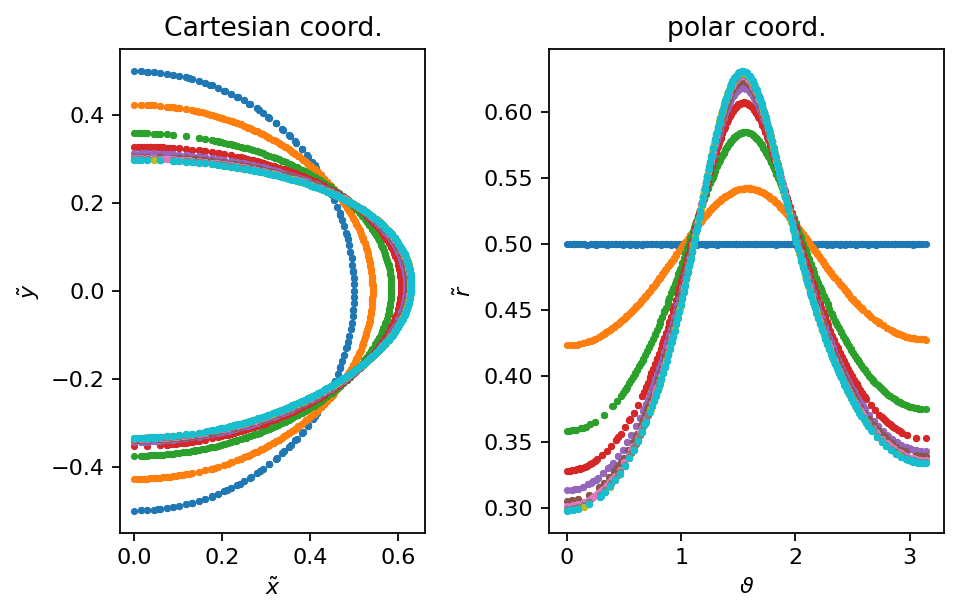

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
for i, (shape_xy, shape_rphi) in enumerate(zip(if_data[::10], shape_polar[::10])):
    ax1.scatter(shape_xy[:, 1], shape_xy[:, 0], s=5)
    ax2.scatter(shape_rphi[:, 1], shape_rphi[:, 0], s=5)
    ax1.set_aspect("equal")

ax1.set_xlabel(r"$\tilde{x}$")
ax1.set_ylabel(r"$\tilde{y}$")
ax2.set_xlabel(r"$\vartheta$")
ax2.set_ylabel(r"$\tilde{r}$")
ax1.set_title("Cartesian coord.")
ax2.set_title("polar coord.")
plt.savefig(f"{output}/shape_over_time.svg", bbox_inches="tight")

In [12]:
def project_velocity(normal: pt.Tensor, velocity: pt.Tensor):
    vn = -(velocity * normal).sum(dim=1)
    tangential = pt.zeros_like(normal)
    tangential[:, 0] = normal[:, 1]
    tangential[:, 1] = -normal[:, 0]
    vt = (velocity * tangential).sum(dim=1)
    return pt.stack((vn, vt)).T

projected_velocity = [project_velocity(i[:, 2:4], i[:, 4:]) for i in if_data]

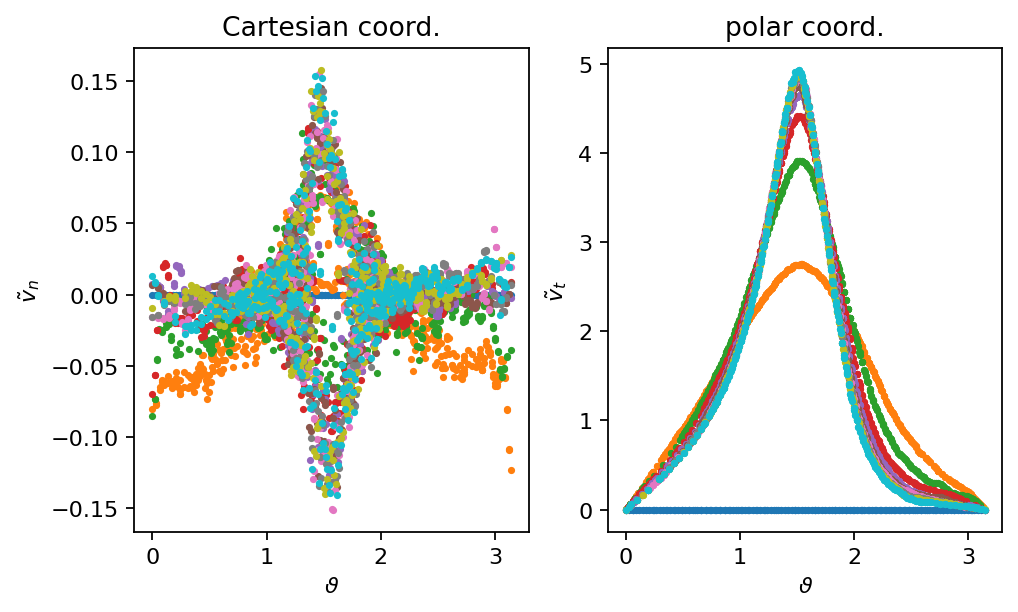

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
for i, (rphi, vel) in enumerate(zip(shape_polar[::10], projected_velocity[::10])):
    ax1.scatter(rphi[:, 1], vel[:, 0], s=5)
    ax2.scatter(rphi[:, 1], vel[:, 1], s=5)

ax1.set_xlabel(r"$\vartheta$")
ax1.set_ylabel(r"$\tilde{v}_n$")
ax2.set_xlabel(r"$\vartheta$")
ax2.set_ylabel(r"$\tilde{v}_t$")
ax1.set_title("Cartesian coord.")
ax2.set_title("polar coord.")
plt.savefig(f"{output}/velocity_projected_over_time.svg", bbox_inches="tight")

## Creating models for deformation and velocity

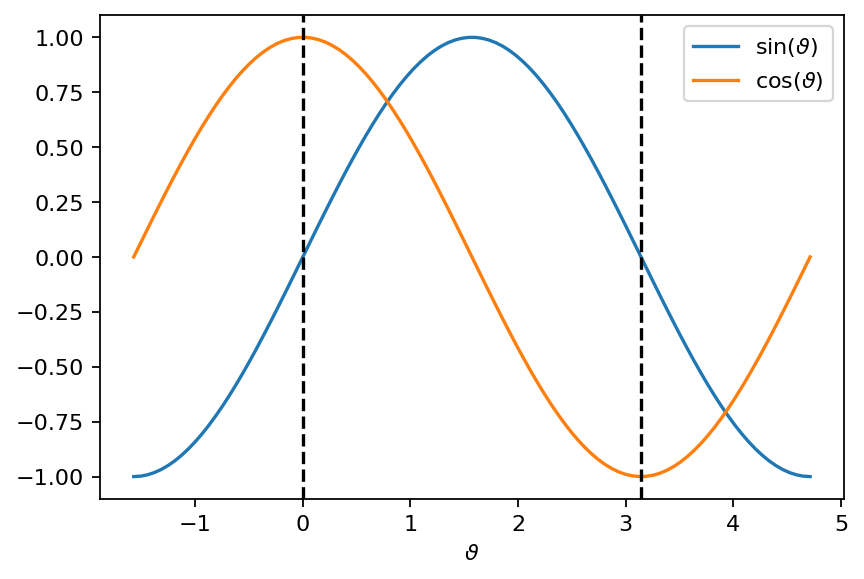

In [14]:
phi = pt.linspace(-np.pi/2, 1.5*np.pi, 100)
plt.plot(phi, phi.sin(), label=r"$\mathrm{sin}(\vartheta)$")
plt.plot(phi, phi.cos(), label=r"$\mathrm{cos}(\vartheta)$")
plt.xlabel(r"$\vartheta$")
plt.legend()
plt.axvline(0.0, ls="--", c="k")
plt.axvline(np.pi, ls="--", c="k")
plt.savefig(f"{output}/sin_symmetry.svg", bbox_inches="tight")

In [15]:
class BaseNN(pt.nn.Module):
    """Simple fully-connected neural network.
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.n_inputs = kwargs.get("n_inputs", 1)
        self.n_outputs = kwargs.get("n_outputs", 1)
        self.n_layers = kwargs.get("n_layers", 1)
        self.n_neurons = kwargs.get("n_neurons", 10)
        self.activation = kwargs.get("activation", pt.sigmoid)
        self.layers = pt.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(pt.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(pt.nn.Linear(
                    self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(pt.nn.Linear(self.n_neurons, self.n_outputs))

    def forward(self, x):
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)


def optimize_model(model: pt.nn.Module, x_train: pt.Tensor, y_train: pt.Tensor,
                   x_val: pt.Tensor, y_val: pt.Tensor, epochs: int=1000,
                   lr: float=0.001, save_best: str="") ->Tuple[List[float], List[float]]:
    criterion = pt.nn.MSELoss()
    optimizer = pt.optim.Adam(params=model.parameters(), lr=lr)
    best_val_loss, best_train_loss = 1.0e5, 1.0e5
    train_loss, val_loss = [], []
    for e in range(1, epochs+1):
        optimizer.zero_grad()
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with pt.no_grad():
            prediction = model(x_val).squeeze()
            loss = criterion(prediction, y_val)
            val_loss.append(loss.item())
        print("\r", "Training/validation loss epoch {:5d}: {:10.5e}, {:10.5e}".format(
            e, train_loss[-1], val_loss[-1]), end="")
        if isdir(save_best):
            if train_loss[-1] < best_train_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_train.pt")
                best_train_loss = train_loss[-1]
            if val_loss[-1] < best_val_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_val.pt")
                best_val_loss = val_loss[-1]
    return train_loss, val_loss

In [16]:
save_model_in = f"{output}/rise_velocity/"
!mkdir -p $save_model_in

model_params = {
    "n_inputs": 1,
    "n_outputs": 1,
    "n_layers": 3,
    "n_neurons": 50,
    "activation": pt.nn.ReLU()
}

rise_model = BaseNN(**model_params)
tloss, _ = optimize_model(rise_model, write_times.unsqueeze(-1), uxc, pt.zeros((2,1)), pt.zeros(2), save_best=save_model_in)

 Training/validation loss epoch  1000: 3.30085e-05, 8.20911e-05

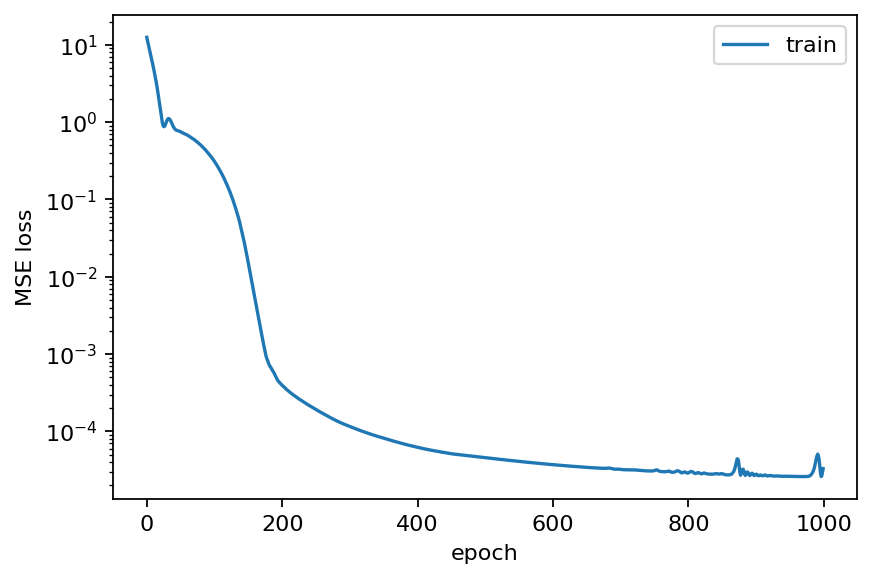

In [17]:
plt.plot(range(len(tloss)), tloss, label="train")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig(f"{output}/rise_loss.svg", bbox_inches="tight")

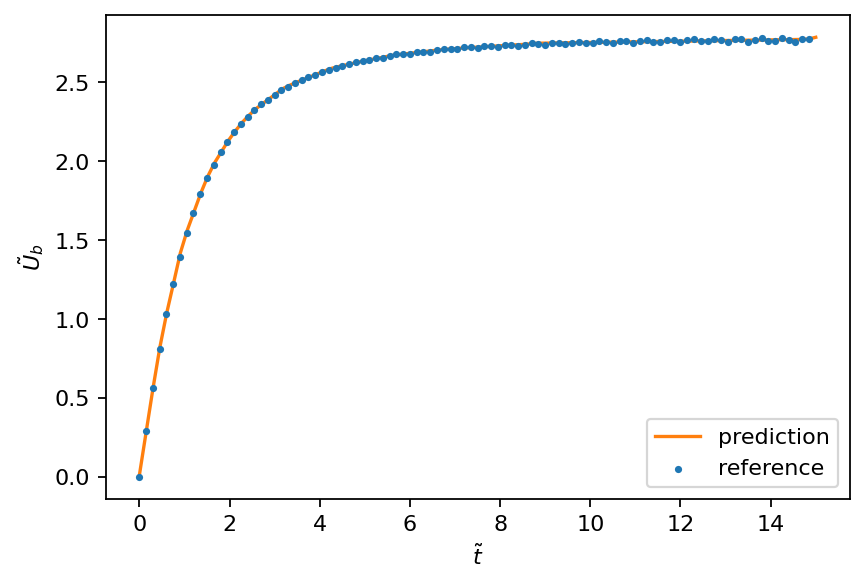

In [18]:
rise_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
plt.scatter(write_times, uxc, s=5, label="reference", zorder=5)
t_plot = pt.linspace(0, 15, 100)
pred = rise_model(t_plot.unsqueeze(-1)).detach()
plt.plot(t_plot, pred, c="C1", label="prediction")
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{U}_b$")
plt.savefig(f"{output}/rise_prediction.svg", bbox_inches="tight")

In [19]:
def split_train_test(feature: List[pt.Tensor], label: List[pt.Tensor],
                     times: pt.Tensor, train_ratio: float
                    ) -> Tuple[pt.Tensor, pt.Tensor, pt.Tensor, pt.Tensor]:
    """Stack time series of features and label and split intro train/test.

    :param feature: list of feature tensors at different time instances
    :type feature: List[pt.Tensor]
    :param label: list of label tensors at different time instances
    :type feature: List[pt.Tensor]
    :param times: snapshot times corresponding to elements in *feature*
    :type times: pt.Tensor
    :param train_ratio: fraction of the data to use for training; must be
        between zero and one
    :type train_ratio: float
    :return: stacked feature tensors for training and testing
    :rtype: Tuple[pt.Tensor, pt.Tensor, pt.Tensor, pt.Tensor]
    """
    assert len(feature) == len(label)
    assert len(feature) == len(times)
    assert 0 < train_ratio < 1.0
    n_train = int(len(feature)*train_ratio)
    probs = pt.ones_like(times)
    train_idx = pt.multinomial(probs, n_train)
    probs[train_idx] = 0.0
    test_idx = pt.multinomial(probs, len(times)-n_train)
    assert len(test_idx) + len(train_idx) == len(times)
    assert (len(test_idx) > 0) and (len(train_idx) > 0)
    total_train = sum([len(feature[i]) for i in train_idx])
    total_test = sum([len(feature[i]) for i in test_idx])
    f_train, l_train = pt.zeros((total_train, 2)), pt.zeros(total_train)
    f_test, l_test = pt.zeros((total_test, 2)), pt.zeros(total_test)
    start = 0
    for i in train_idx:
        end = start+len(feature[i])
        f_train[start:end, 0] = feature[i]
        f_train[start:end, 1] = times[i]
        l_train[start:end] = label[i]
        start = end
    start = 0
    for i in test_idx:
        end = start+len(feature[i])
        f_test[start:end, 0] = feature[i]
        f_test[start:end, 1] = times[i]
        l_test[start:end] = label[i]
        start = end
    return f_train, l_train, f_test, l_test

In [20]:
theta = [data[:, 1] for data in shape_polar]
rad = [data[:, 0] for data in shape_polar]
vel = [data[:, 1] for data in projected_velocity]
f_vt_train, l_vt_train, f_vt_test, l_vt_test = split_train_test(theta, vel, write_times, 0.8)
f_r_train, l_r_train, f_r_test, l_r_test = split_train_test(theta, rad, write_times, 0.8)

In [21]:
class VelocityModel(BaseNN):
    """Velocity NN with modified forward pass.
    """
    def __init__(self, **kwargs):
        super(VelocityModel, self).__init__(**kwargs)

    def forward(self, x):
        sin = pt.sin(x[:, 0]).unsqueeze(-1)
        x = pt.stack((pt.cos(x[:, 0]), x[:, 1])).T
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)*sin

In [22]:
save_model_in = f"{output}/interface_velocity/"
!mkdir -p $save_model_in

model_params = {
    "n_inputs": 2,
    "n_outputs": 1,
    "n_layers": 5,
    "n_neurons": 60,
    "activation": pt.nn.ReLU()
}

vel_model = VelocityModel(**model_params)
tloss, vloss = optimize_model(vel_model, f_vt_train, l_vt_train, f_vt_test, l_vt_test, save_best=save_model_in)

 Training/validation loss epoch  1000: 6.50633e-04, 6.28081e-04

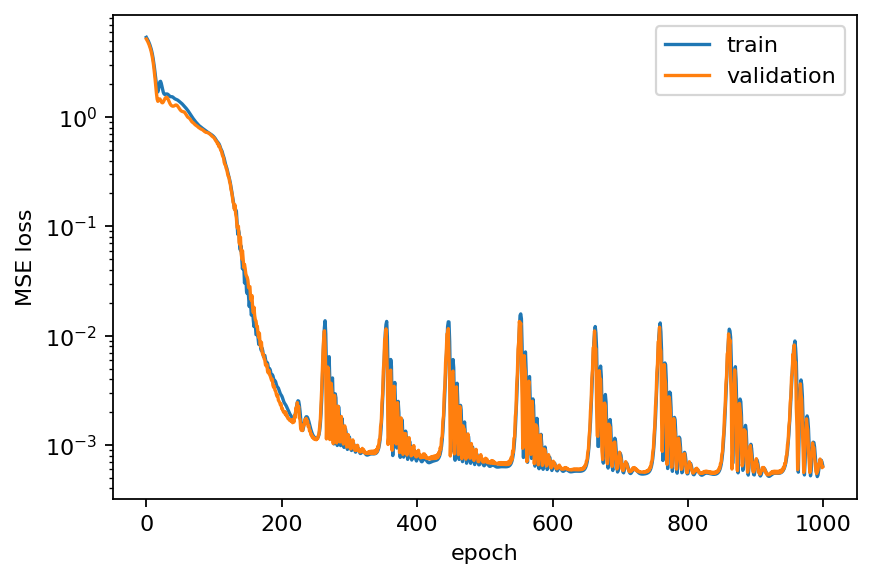

In [23]:
plt.plot(range(len(tloss)), tloss, label="train")
plt.plot(range(len(vloss)), vloss, label="validation")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig(f"{output}/vt_loss.svg", bbox_inches="tight")

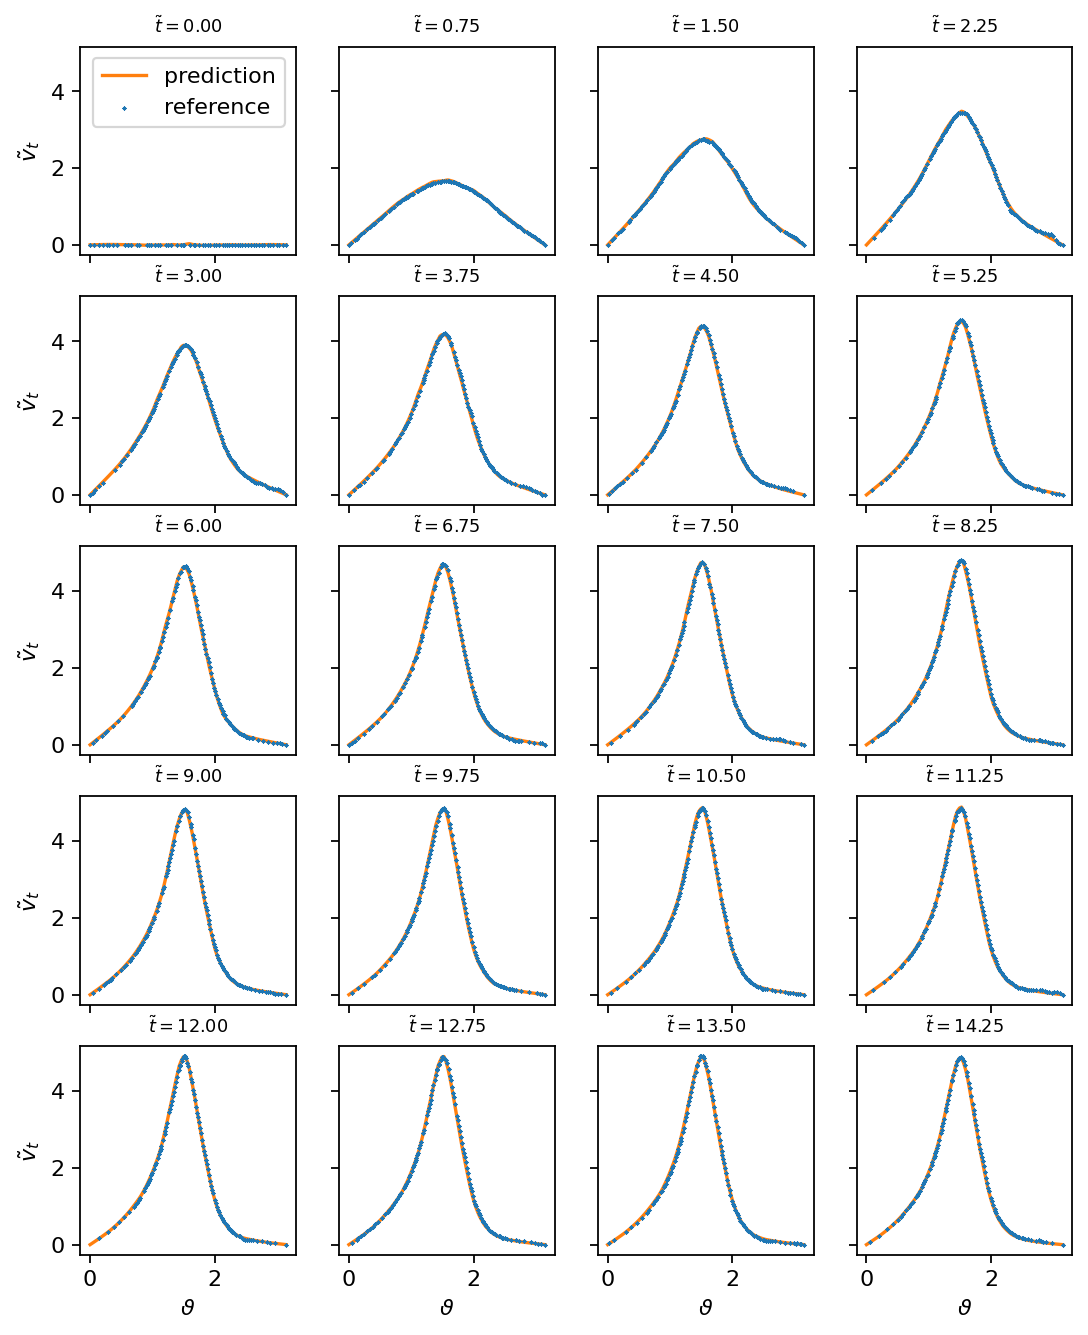

In [24]:
save_model_in = f"{output}/interface_velocity/"
vel_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
f = pt.zeros(100, 2)
f[:, 0] = pt.linspace(0, np.pi, 100)
idx = list(range(0, 100, 5))
n_rows = len(idx) / 4 if len(idx) % 4 == 0 else len(idx) / 4 + 1
fig, axarr = plt.subplots(int(n_rows), 4, figsize=(8, n_rows*2), sharex=True, sharey=True)
row, col = 0, 0
for i in idx:
    f[:, 1] = write_times[i]
    vel_i = vel_model(f).detach()
    axarr[row, col].plot(f[:, 0], vel_i, c="C1", label="prediction")
    axarr[row, col].scatter(shape_polar[i][::4, 1], projected_velocity[i][::4, 1], marker="x", s=1, c="C0", zorder=5, label="reference")
    axarr[row, col].set_title(r"$\tilde{t}=" +r"{:2.2f}$".format(write_times[i]), fontsize=8)
    if col == 0 and row == 0: axarr[row, col].legend(loc=0)
    col += 1
    if col % 4 == 0:
        row += 1
        col = 0
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{v}_t$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\vartheta$")
plt.savefig(f"{output}/vt_prediction.svg", bbox_inches="tight")

In [25]:
class RadiusModel(BaseNN):
    """Radius NN with modified forward pass.
    """
    def __init__(self, **kwargs):
        super(RadiusModel, self).__init__(**kwargs)

    def forward(self, x):
        x = pt.stack((pt.cos(x[:, 0]), x[:, 1])).T
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [26]:
save_model_in = f"{output}/radius/"
!mkdir -p $save_model_in

model_params = {
    "n_inputs": 2,
    "n_outputs": 1,
    "n_layers": 6,
    "n_neurons": 50,
    "activation": pt.nn.ReLU()
}

r_model = RadiusModel(**model_params)
tloss, vloss = optimize_model(r_model, f_r_train, l_r_train, f_r_test, l_r_test, 2000, save_best=save_model_in)

 Training/validation loss epoch  2000: 4.99102e-06, 4.91706e-06

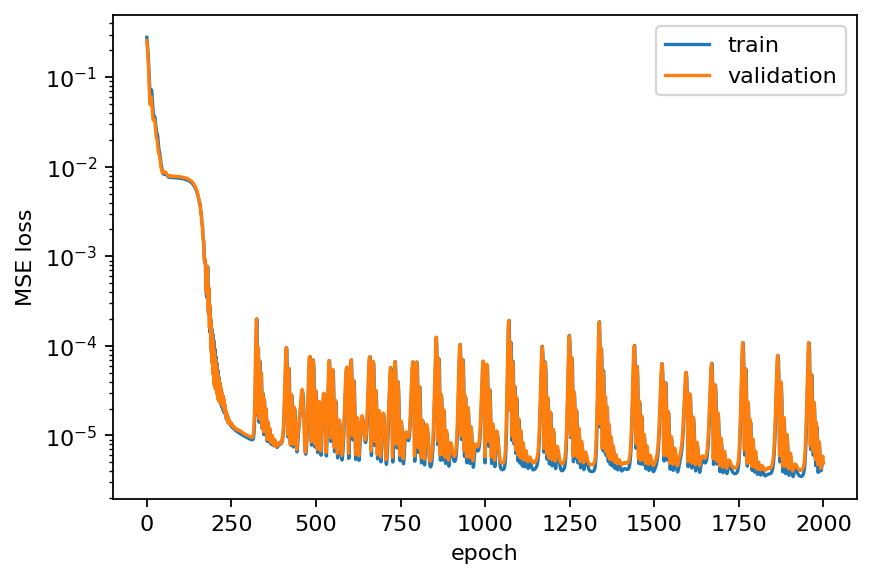

In [27]:
plt.plot(range(len(tloss)), tloss, label="train")
plt.plot(range(len(vloss)), vloss, label="validation")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig(f"{output}/rad_loss.svg", bbox_inches="tight")

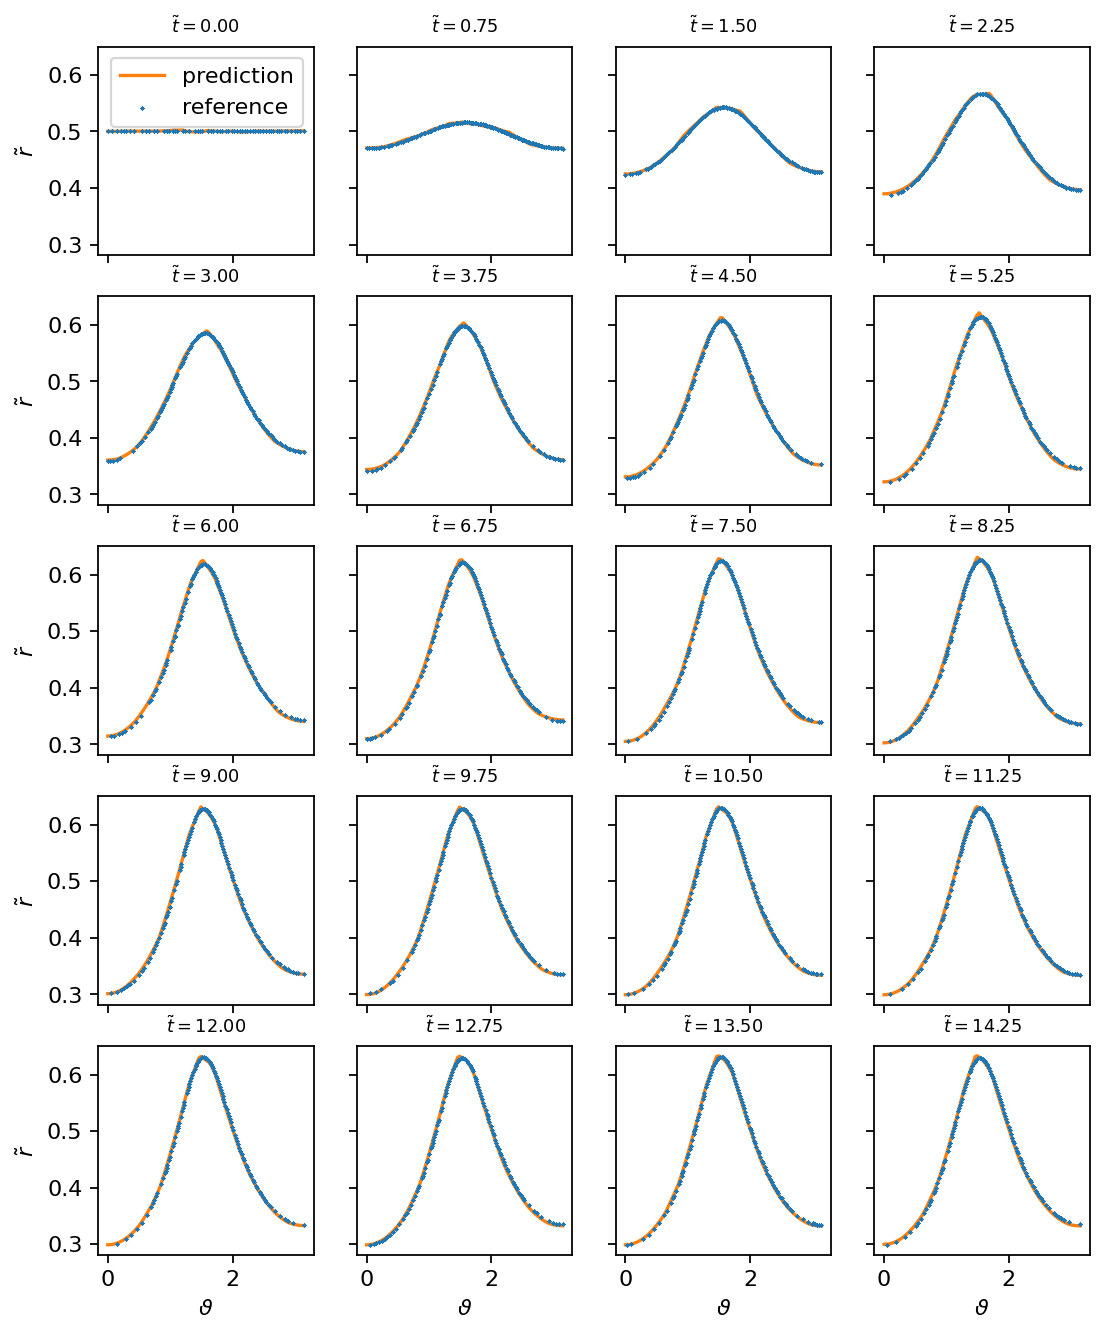

In [28]:
r_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
idx = list(range(0, 100, 5))
n_rows = len(idx) / 4 if len(idx) % 4 == 0 else len(idx) / 4 + 1
f = pt.zeros((100, 2))
f[:, 0] = pt.linspace(0, np.pi, 100)
fig, axarr = plt.subplots(int(n_rows), 4, figsize=(8, n_rows*2), sharex=True, sharey=True)
row, col = 0, 0
for i in idx:
    f[:, 1] = write_times[i]
    r_i = r_model(f).detach()
    axarr[row, col].plot(f[:, 0], r_i, c="C1", label="prediction")
    axarr[row, col].scatter(shape_polar[i][::4, 1], shape_polar[i][::4, 0], marker="x", s=1, c="C0", zorder=5, label="reference")
    axarr[row, col].set_title(r"$\tilde{t}=" +r"{:2.2f}$".format(write_times[i]), fontsize=8)
    if col == 0 and row == 0: axarr[row, col].legend(loc=0)
    col += 1
    if col % 4 == 0:
        row += 1
        col = 0
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{r}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\vartheta$")
plt.savefig(f"{output}/rad_prediction.svg", bbox_inches="tight")

In [29]:
#traced_vel = pt.jit.trace(vel_model, pt.rand((1,2)))
#traced_vel.save(f"{output}velocity_model.pt")

In [30]:
#jitm = pt.jit.load(f"{output}velocity_model.pt")
#jitm(pt.rand((2,2)))

In [31]:
def add(a, b):
    return a + b

a, b = pt.ones(3)*4, pt.ones(3)*2
trace = pt.jit.trace(add, (a, b))
print(trace.graph)

graph(%a : Double(3, strides=[1], requires_grad=0, device=cpu),
      %b : Double(3, strides=[1], requires_grad=0, device=cpu)):
  %2 : int = prim::Constant[value=1]() # <ipython-input-31-a0ee844b0cc6>:2:0
  %3 : Double(3, strides=[1], requires_grad=0, device=cpu) = aten::add(%a, %b, %2) # <ipython-input-31-a0ee844b0cc6>:2:0
  return (%3)



In [32]:
save_model_in = f"{output}/rise_velocity/"
rise_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
traced_rise_vel = pt.jit.trace(rise_model, pt.rand((1,1)))
traced_rise_vel.save(f"{output}/rv_model.pt")

In [33]:
save_model_in = f"{output}/interface_velocity/"
vel_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
traced_vel = pt.jit.trace(vel_model, pt.rand((1,2)))
traced_vel.save(f"{output}/iv_model.pt")

In [34]:
save_model_in = f"{output}/radius/"
r_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
traced_r = pt.jit.trace(r_model, pt.rand((1,2)))
traced_r.save(f"{output}/r_model.pt")

In [35]:
class WrapperModel(pt.nn.Module):
    def __init__(self, model, xmin, xmax):
        super(WrapperModel, self).__init__()
        self._model = model
        self._xmin = xmin
        self._xmax = xmax
        self._range = xmax - xmin
    
    def scale(self, x):
        return (x-self._xmin) / self._range

    def inverse_scale(self, x):
        return x*self._range + self._xmin

    def forward(self, x):
        x = self.scale(x)
        x = self._model(x)
        print(x)
        return self.inverse_scale(x)

class IdentityModel(pt.nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()
    def forward(self, x):
        return x

    
model = IdentityModel()
wrapper = WrapperModel(model, 0, 5)
wrapper(5)

1.0


5.0

In [36]:
class CombinedModel(pt.nn.Module):
    def __init__(self, model1, model2):
        super(CombinedModel, self).__init__()
        self._model1 = model1
        self._model2 = model2

    def forward(self, x):
        x = self._model1(x)
        x = self._model2(x)
        return x

cmodel =CombinedModel(model, wrapper)
cmodel(5)

1.0


5.0

## Single-phase flow simulations with mass transfer

## Analyzing the results